In [2]:
from wordcloud import WordCloud
from collections import Counter
from konlpy.tag import Twitter as Okt
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("word_cloud").getOrCreate()

In [4]:
twitter = Okt()

/opt/conda/lib/python3.11/site-packages/konlpy/tag/_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [25]:
df=spark.read.csv('political_top50.csv', header=True)
print(df)

DataFrame[comment: string, num_likes: string, tag: string, date: string]


In [26]:
word_list=[]
sentiment_file='dictionary.csv'
sentiment_df=pd.read_csv(sentiment_file, delimiter=',', header=None, encoding='utf-8')
print(sentiment_df)

         0      1
0     word  score
1      선넘지     -1
2      선넘네     -1
3     국개의원     -2
4    국개의원들     -2
..     ...    ...
328    좋네ㅔ      1
329    쳐막네     -1
330  화이팅이당      1
331    뻐꾸기     -1
332    개같네     -1

[333 rows x 2 columns]


In [27]:
for comment_row in df.select("comment").collect():
    comment_value = comment_row["comment"]
    if comment_value is not None:
        # sentences_tag = twitter.pos(comment_value)
        # for word, tag in sentences_tag:
        #     if tag in ['Noun', 'Adjective', 'Verb']:
        #         word_list.append(word)
        words=comment_value.split(' ')
        for w in words:
            found = sentiment_df[sentiment_df[0] == w]  # 단어 검색
            if not found.empty:
                word_list.append(found.iloc[0,0])

In [28]:
counts = Counter(word_list)
tags=counts.most_common(40)
print(tags)

# 단어와 빈도수를 딕셔너리 자료료 바꾸서 key(단어)과 values(빈도수)를 데이터프레임으로 저장
count_tokens = pd.DataFrame(dict(counts).items(),columns=['word','count'])

[('빨대', 11), ('종이빨대', 9), ('참', 3), ('탁상행정', 3), ('이재명', 3), ('지원', 3), ('플라스틱빨대', 2), ('문재인', 2), ('저놈', 2), ('선넘지않았나', 1), ('문죄인', 1), ('시발', 1), ('이랫다저랫다', 1), ('취소', 1), ('극혐', 1), ('대책은', 1), ('종이맛', 1), ('차라리', 1), ('정작', 1), ('좌파정권', 1), ('드디어', 1), ('현수막이나', 1), ('싫어할만한', 1), ('어이엄네', 1), ('감방가자', 1), ('민주당', 1), ('탁상행정의', 1), ('재명이는', 1), ('어이없네', 1), ('총선용', 1), ('미국', 1), ('미개한', 1), ('옳다', 1), ('으이그', 1), ('엿맥이냐', 1)]


In [32]:
# 토큰화된 단어와 감성 사전 속 단어 매칭(merge)
sentiment_file='dictionary.csv'
sentiment_df2=pd.read_csv(sentiment_file, delimiter=',', header=0, encoding='utf-8')
print(sentiment_df)

sentword_df = pd.merge(left=sentiment_df2, right=count_tokens, how='inner', on='word')

         0      1
0     word  score
1      선넘지     -1
2      선넘네     -1
3     국개의원     -2
4    국개의원들     -2
..     ...    ...
328    좋네ㅔ      1
329    쳐막네     -1
330  화이팅이당      1
331    뻐꾸기     -1
332    개같네     -1

[333 rows x 2 columns]


In [34]:
print(sentword_df.head())

# 'score' 컬럼을 정수형으로 변환
sentword_df['score'] = sentword_df['score'].astype(int)

    word  score  count
0    문죄인      2      1
1    이재명     -1      3
2   재명이는     -1      1
3   좌파정권      1      1
4  현수막이나     -1      1


In [35]:
# 긍, 부정 라벨링

sentword_df['senti_cat'] = list(map(lambda x:'긍정' if  x> 0 else '부정' if x < 0 else '중립', sentword_df.score))

In [43]:
# 감성 단어군에 따라 색깔 지정
color_to_words = {
    'red' : list(sentword_df.loc[sentword_df.senti_cat == '부정', 'word']),
    'navy': list(sentword_df.loc[sentword_df.senti_cat == '긍정', 'word'])}


In [44]:
default_color = 'grey'

# 각각의 단어에 색깔 지정
class SimpleGroupedColorFunc(object):
    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)

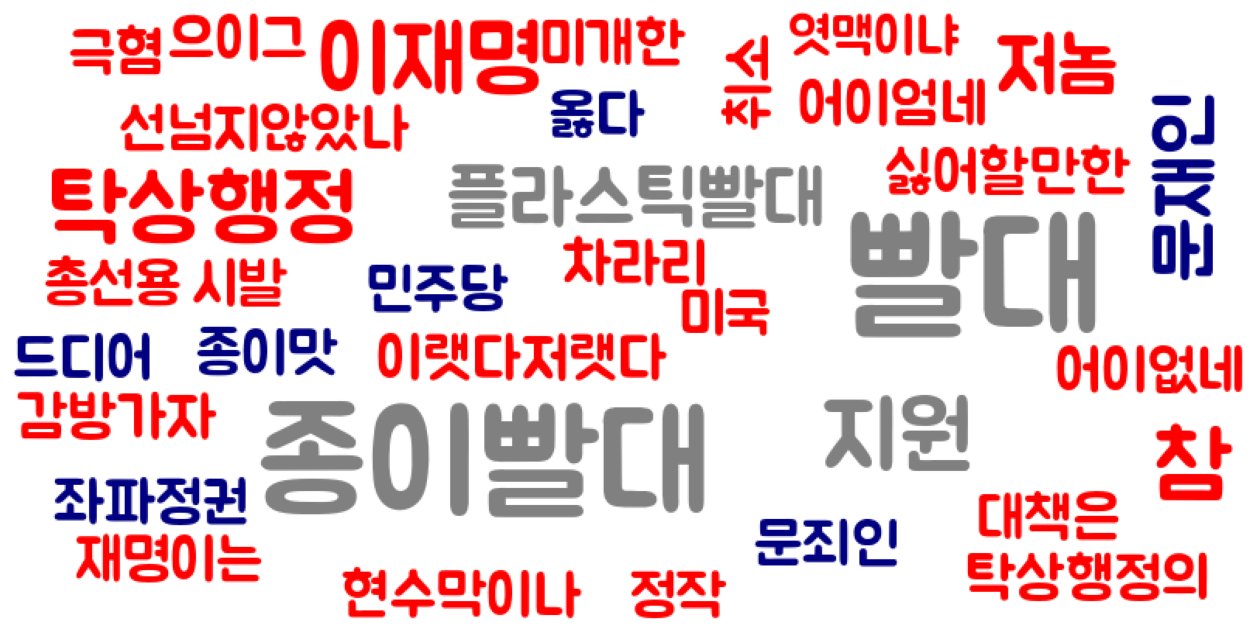

In [45]:
simple_color_func = SimpleGroupedColorFunc(color_to_words, default_color)
wc = WordCloud(font_path='BMJUA_otf.otf', scale=2.0, max_font_size=50, color_func = simple_color_func,
               background_color="white").generate_from_frequencies(counts)
plt.figure(figsize = (16,  16))
plt.imshow(wc)
plt.axis("off")

cloud = wc.generate_from_frequencies(dict(tags))
#생성된 WordCloud를 test.jpg로 보낸다.
cloud.to_file('political_top50_dict_emotion.jpg')

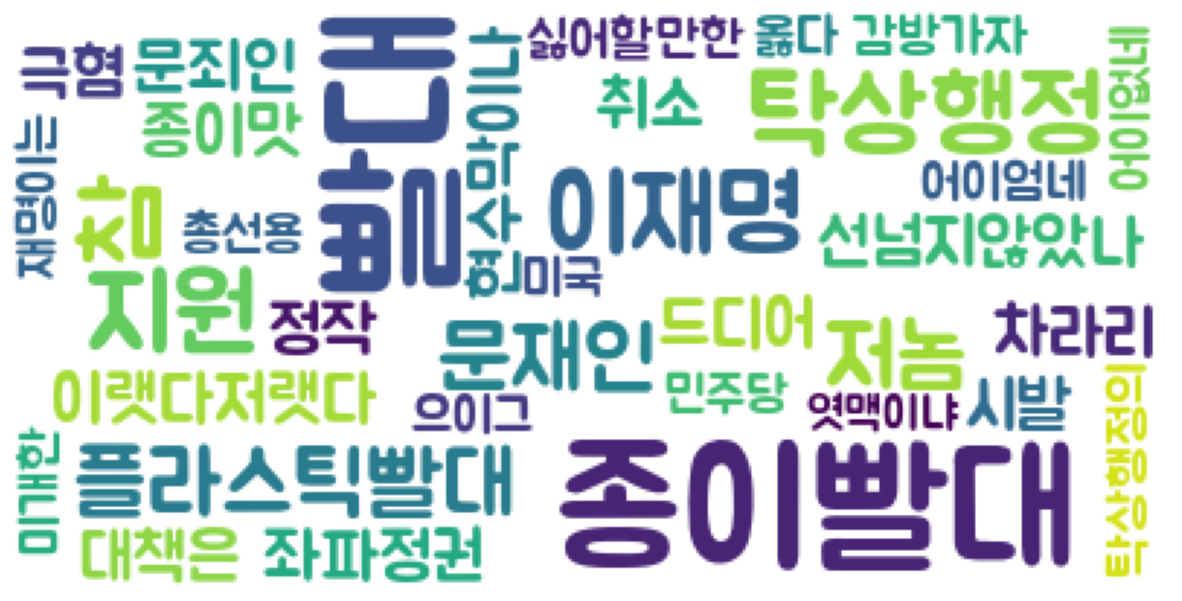

In [22]:
# WordClound 생성
# 한글을 분석하기 위해 font를 한글로 지정
wc = WordCloud(font_path='BMJUA_otf.otf', background_color="white", max_font_size=60, max_words=1000)
cloud = wc.generate_from_frequencies(dict(tags))

#생성된 WordCloud를 test.jpg로 보낸다.
cloud.to_file('political_top50_dict.jpg')

plt.figure(figsize=(15,15))
plt.imshow(cloud)
plt.axis("off")
plt.show()